In [13]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# Preprocessing

In [14]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [15]:
train.shape

(165034, 11)

In [16]:
X = train.drop(columns='Exited')
y = train.Exited

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y)

In [18]:
prepro = Preprocessing()

In [19]:
X_train_scld = prepro.fit_transform(X_train)
X_test_scld = prepro.transform(X_test)

In [20]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [21]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Fit

In [22]:
params = {
    'hidden_layer_sizes':(100,),
    'max_iter':500,
    'activation':'relu',
    'learning_rate':'constant',
    'learning_rate_init':0.0001
    
}

nn = MLPClassifier(
    **params, random_state=42)

In [23]:
nn.fit(X_train_balanced, y_train_balanced)

MLPClassifier(learning_rate_init=0.0001, max_iter=500, random_state=42)

In [24]:
pred = nn.predict(X_test_scld)
pred_proba = nn.predict_proba(X_test_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [25]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.4f}')

Roc Auc Score : 0.8873


In [26]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     32529
           1       0.54      0.79      0.64      8730

    accuracy                           0.82     41259
   macro avg       0.74      0.81      0.76     41259
weighted avg       0.85      0.82      0.83     41259



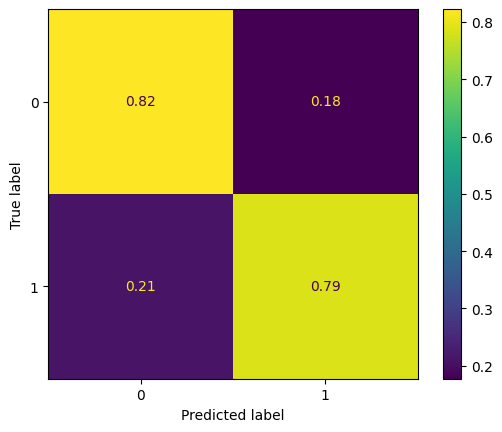

In [27]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred, normalize='true')).plot()

# Submission

In [28]:
X_val_scld = prepro.transform(test)

In [29]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [30]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [31]:
submission

,Exited
id,
165034,0.094278
165035,0.953314
165036,0.098446
165037,0.466109
165038,0.612698
...,...
275052,0.122026
275053,0.190044
275054,0.066209


In [32]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [34]:
submission.to_csv(f"submission/{name}.csv")